# Capacity Data Triggers

This notebook works with:

- Clean Data from Planet and ERA-?5

  * Reads processed data for clusters
  * Calculates data triggers
  * Gets data count for triggers
  * Store the data as a NetCDF file

In [20]:
import sys
import os
import matplotlib.dates as mdates
cp = '/home/jupyter-gabriel/' #'I:/My Drive/'
sys.path.append(cp + "projects/suyana")
from scripts.utils.functions import *
#from scripts.utils.data_cleaning import *

from scipy.stats import norm
from scipy.signal import butter, filtfilt

In [2]:
# Data primary path
dpp = 'suyana/'
# Data inputs path
dip = 'suyana/inputs/'
# Data features path
dfp = 'suyana/features/'
# Data outputs path
dop = 'suyana/outputs/'
# Data reports path
drp = 'suyana/reports/'
# Data models path
dmp = 'suyana/models/'
# Data displays path
ddp = 'suyana/displays/'
# Data geometries path
dgp = 'suyana/geometries/'

In [15]:
def create_rolling_mean_ds(ds_daily_anomalies_swc, window_size=7, time_variable_name='valid_time'):
    ds_daily_rolling_filtered_anomalies_swc = ds_daily_anomalies_swc.copy(deep=True).rolling({time_variable_name: window_size}).mean(center=True)
    ds_daily_rolling_filtered_anomalies_swc = ds_daily_rolling_filtered_anomalies_swc.assign_coords({time_variable_name: pd.to_datetime(ds_daily_rolling_filtered_anomalies_swc[time_variable_name].values)})
    return ds_daily_rolling_filtered_anomalies_swc 

In [16]:
def generate_yearly_accumulated_anomalies(ds_daily_rolling_filtered_anomalies_swc, window, params_select={'cluster':1}, variable_name='swc_adjusted'):
    
    df_daily_rolling_filtered_anomalies_swc = ds_daily_rolling_filtered_anomalies_swc.isel(params_select).to_dataframe()

    yearly_accumulated_anomalies = df_daily_rolling_filtered_anomalies_swc[variable_name].groupby(df_daily_rolling_filtered_anomalies_swc.index.year).sum().copy()

    for year in range(yearly_accumulated_anomalies.index.min(), yearly_accumulated_anomalies.index.max() + 1):
        first_value = list(window.values())[0]
        last_value = list(window.values())[0]

        start_month, start_day = map(int, first_value[0].split('-'))
        end_month, end_day = map(int, last_value[1].split('-'))

        start_date = f'{year}-{first_value[0]}'

        if (end_month < start_month) or (end_month == start_month and end_day < start_day):
            end_date = f'{year + 1}-{last_value[1]}'
        else:
            end_date = f'{year}-{last_value[1]}'

        window_data = df_daily_rolling_filtered_anomalies_swc[start_date:end_date]
        yearly_accumulated_anomalies[year] = window_data[variable_name].sum()
     
    return df_daily_rolling_filtered_anomalies_swc, yearly_accumulated_anomalies 

In [17]:
def get_activation_years(yearly_accumulated_anomalies, percentile_list, side='lower'):
    percentile_values = np.percentile(yearly_accumulated_anomalies, percentile_list)
    activation_years_dict = {}

    for i, ithreshold in enumerate(percentile_values):
        if side=='lower':
            idf = yearly_accumulated_anomalies[yearly_accumulated_anomalies < ithreshold].copy()
        elif side=='upper':
            idf = yearly_accumulated_anomalies[yearly_accumulated_anomalies >= ithreshold].copy()
        else:
            raise ValueError(f"side must be lower or upper")
        activation_years_dict[f'P{percentile_list[i]}'] = idf
    
    return activation_years_dict 

In [18]:
 
def generate_yearly_activation_dataframe(yearly_accumulated_anomalies, start_year, end_year, activation_years_dict, percentile_list):
    years = range(start_year, end_year + 1)
    columns = [f'P{p}_activation_date' for p in percentile_list] + \
              [f'P{p}_trigger' for p in percentile_list] + \
                ['accumulated_anomaly', 'percentile']

    yearly_activation_df = pd.DataFrame(index=years, columns=columns)

    percentile_values = np.percentile(yearly_accumulated_anomalies, percentile_list)

    for i, threshold in enumerate(percentile_values):
        key = f'P{percentile_list[i]}'
        activation_series = activation_years_dict.get(key, None)

        if activation_series is not None:
            activation_years = activation_series.index.intersection(yearly_activation_df.index)

            yearly_activation_df[f'P{percentile_list[i]}_activation_date'] = False
            yearly_activation_df.loc[activation_years, f'P{percentile_list[i]}_activation_date'] = True
            yearly_activation_df.loc[activation_years, f'P{percentile_list[i]}_trigger'] = threshold.round(2)
   
    yearly_activation_df['accumulated_anomaly'] = yearly_accumulated_anomalies.reindex(yearly_activation_df.index).round(2)

    anomalies = yearly_accumulated_anomalies.reindex(yearly_activation_df.index).dropna()
    sorted_anomalies = anomalies.sort_values()
    total_anomalies = len(sorted_anomalies)

    anomaly_percentiles = sorted_anomalies.rank(method='min').apply(lambda rank: (rank - 1) / (total_anomalies - 1) * 100)
    yearly_activation_df['percentile'] = anomaly_percentiles.reindex(yearly_activation_df.index).round(1)

    return yearly_activation_df 

In [76]:
def create_heatmap(yearly_activation_df, index):
    heatmap_data = yearly_activation_df[[x for x in yearly_activation_df.columns if x.endswith('trigger')]].copy()

    for i, var in enumerate(heatmap_data):
        heatmap_data[var] = heatmap_data[var].apply(lambda x: i+1 if pd.notna(x) and x else 0)
    

    fig, ax = plt.subplots(figsize=(10, 2))
    cmap = sns.color_palette(['white', 'mediumaquamarine', 'gold', 'coral'])
    sns.heatmap(
        heatmap_data.T, 
        cmap=cmap, 
        cbar=False, 
        linewidths=0.005, 
        linecolor='whitesmoke', 
        ax=ax
    )
    ax.set_xticklabels(yearly_activation_df.index, rotation=45, fontsize=10)
    ax.set_yticklabels(heatmap_data.columns.str.replace('_trigger', '').to_list(), rotation=0, fontsize=10)
    ax.set_title(f"Activation heatmap for cluster_{index}", fontsize=10)
    #fig.savefig(f"../figs/activation_heatmap_lat_{lat_index}_lon_{lon_index}.png", dpi=300)
    plt.show()

In [77]:
path = dip
files = os.listdir(path)
files = [f for f in files if f.startswith("drought_canton_cluster")]
id_canton = [int(files[i].split("_")[2].split(".")[0]) for i in range(len(files))]

In [ ]:
windows = {
    'crop_cycle': ('11-01', '04-30'),
}
percentile_list = [80, 90, 95]
start_year = 2002
end_year = 2023
for id in id_canton:
    print(f'Canton: {id}')
    ds = xr.open_dataset(path + 'canton_cluster_' + str(id) + '.nc')
    clusters = list(set(ds.cluster.values))
    
    df_canton = pd.DataFrame()
    df_daily_canton = pd.DataFrame()
    for i in range(len(clusters)):
        ds_rolling = create_rolling_mean_ds(ds, time_variable_name='time')
        df_anomalies, cum_anomalies = generate_yearly_accumulated_anomalies(ds_rolling, window=windows,params_select={'cluster':i}, variable_name='negative_anomaly')
        activation_years_dict =  get_activation_years(cum_anomalies, percentile_list,side='upper')
        df_year = generate_yearly_activation_dataframe(cum_anomalies, start_year, end_year, activation_years_dict, percentile_list)

        df_year = df_year.reset_index(names='year')

        orig_cols = df_year.columns
        df_year['id_canton'] = id
        df_year['id_cluster'] = clusters[i]
        df_year = df_year[['id_canton', 'id_cluster'] + list(orig_cols)]

        df_canton = pd.concat([df_canton, df_year], axis=0)

        df_anomalies['cum_neg_anomaly'] = df_anomalies.groupby(['cluster', 'crop_year', 'flag_summer'])['negative_anomaly'].cumsum()
        df_anomalies = df_anomalies.reset_index(names='time')
        df_daily_canton = pd.concat([df_daily_canton, df_anomalies], axis=0)
        
    
    df_daily_canton['time'] = df_daily_canton['time'].dt.strftime("%Y-%m-%d")

    df_canton.to_csv(dop + f'drought_yearly_activation_dates_canton_{id}.csv', index=False)
    df_daily_canton.to_csv(dop + f'drought_daily_activation_dates_canton_{id}.csv', index=False)


Canton: 190
Canton: 52
Canton: 189
Canton: 210
Canton: 43
Canton: 81
Canton: 209
Canton: 166
Canton: 106
Canton: 55
Canton: 208
Canton: 84
Canton: 198
Canton: 120
Canton: 162
Canton: 128
Canton: 172
Canton: 57
Canton: 196
Canton: 125
Canton: 56
Canton: 173
Canton: 220
Canton: 72
Canton: 171
Canton: 85
Canton: 87
Canton: 158
Canton: 211
Canton: 53
Canton: 169
Canton: 105
Canton: 167
Canton: 70
Canton: 49
Canton: 50
Canton: 129
Canton: 207
Canton: 199
Canton: 127
Canton: 82
Canton: 194
Canton: 86
Canton: 215
Canton: 192
Canton: 214
Canton: 164
Canton: 51
Canton: 163
Canton: 80
Canton: 54
Canton: 237
Canton: 122
Canton: 191
Canton: 45
Canton: 170
Canton: 168
Canton: 195
Canton: 165
Canton: 202
Canton: 121
Canton: 126
Canton: 83
Canton: 218


# Empirical distribution and percentiles of cumulative negative anomalies

In [ ]:
windows = {
    'crop_cycle': ('11-01', '04-30'),
}
percentile_list = [80, 90, 95]
start_year = 2002
end_year = 2023
for id in [43]:
    print(f'Canton: {id}')
    ds = xr.open_dataset(path + 'canton_cluster_' + str(id) + '.nc')
    clusters = list(set(ds.cluster.values))
    
    df_canton = pd.DataFrame()
    df_daily_canton = pd.DataFrame()
    for i in [0]:
        ds_rolling = create_rolling_mean_ds(ds, time_variable_name='time')
        df_anomalies, cum_anomalies = generate_yearly_accumulated_anomalies(ds_rolling, window=windows,params_select={'cluster':i}, variable_name='negative_anomaly')
        activation_years_dict =  get_activation_years(cum_anomalies, percentile_list,side='upper')
        df_year = generate_yearly_activation_dataframe(cum_anomalies, start_year, end_year, activation_years_dict, percentile_list)

        df_year = df_year.reset_index(names='year')

        orig_cols = df_year.columns
        df_year['id_canton'] = id
        df_year['id_cluster'] = clusters[i]
        df_year = df_year[['id_canton', 'id_cluster'] + list(orig_cols)]

        df_canton = pd.concat([df_canton, df_year], axis=0)

        df_anomalies['cum_neg_anomaly'] = df_anomalies.groupby(['cluster', 'crop_year', 'flag_summer'])['negative_anomaly'].cumsum()
        df_anomalies = df_anomalies.reset_index(names='time')
        df_daily_canton = pd.concat([df_daily_canton, df_anomalies], axis=0)
        
    
    df_daily_canton['time'] = df_daily_canton['time'].dt.strftime("%Y-%m-%d")

    df_canton.to_csv(dop + f'drought_yearly_activation_dates_canton_{id}.csv', index=False)
    df_daily_canton.to_csv(dop + f'drought_daily_activation_dates_canton_{id}.csv', index=False)


Canton: 43


In [186]:
years = range(start_year, end_year + 1)
columns = [f'P{p}_activation_date' for p in percentile_list] + \
            [f'P{p}_trigger' for p in percentile_list] + \
            ['accumulated_anomaly', 'percentile']

yearly_activation_df = pd.DataFrame(index=years, columns=columns)

percentile_values = np.percentile(cum_anomalies, percentile_list)

for i, threshold in enumerate(percentile_values):
    key = f'P{percentile_list[i]}'
    activation_series = activation_years_dict.get(key, None)

    if activation_series is not None:
        activation_years = activation_series.index.intersection(yearly_activation_df.index)

        yearly_activation_df[f'P{percentile_list[i]}_activation_date'] = False
        yearly_activation_df.loc[activation_years, f'P{percentile_list[i]}_activation_date'] = True
        yearly_activation_df.loc[activation_years, f'P{percentile_list[i]}_trigger'] = threshold.round(2)

yearly_activation_df['accumulated_anomaly'] = cum_anomalies.reindex(yearly_activation_df.index).round(2)

anomalies = cum_anomalies.reindex(yearly_activation_df.index).dropna()
sorted_anomalies = anomalies.sort_values()
total_anomalies = len(sorted_anomalies)

anomaly_percentiles = sorted_anomalies.rank(method='min').apply(lambda rank: (rank - 1) / (total_anomalies - 1) * 100)
yearly_activation_df['percentile'] = anomaly_percentiles.reindex(yearly_activation_df.index).round(1)

In [ ]:
percentile_list = [80, 90, 95]
df_list = []
for f in files:
    df = pd.read_csv(dop + f)
    df_list.append(df)
df_full = pd.concat(df_list,axis=0)

In [51]:
for p in percentile_list:
    df_full[f'P{p}_activation_date'] = df_full[f'P{p}_activation_date'].astype(int)
df_full = df_full.sort_values(by=['id_canton', 'id_cluster', 'percentile'])

In [ ]:
df_full.to_csv(dip + 'full_year_trigger_cluster.csv', index=False)

In [6]:
gdf = gpd.read_file(dgp + 'dict_canton.gpkg')
gdf['id_canton'] = gdf['id_canton'].fillna(0).astype(int)

In [54]:
df_full = df_full.merge(
    gdf[['id', 'id_cluster', 'id_canton']],
    how = 'left',
    on = ['id_canton', 'id_cluster']
)

In [59]:
gdf[gdf.id_canton==189]

,id_canton,id_cluster,departamen,provincia,municipio,canton,area,new_id_canton,new_id_cluster,id,geometry
1,189,5.0,Santa Cruz,Guarayos,El Puente,El Puente,1398.332915,101,1,101-1,"POLYGON ((-63.56246 -16.25049, -63.58047 -16.3..."
2,189,2.0,Santa Cruz,Guarayos,El Puente,El Puente,1398.332915,101,2,101-2,"POLYGON ((-63.17311 -16.19766, -63.17322 -16.3..."
3,189,6.0,Santa Cruz,Guarayos,El Puente,El Puente,1398.332915,101,3,101-3,"POLYGON ((-63.38219 -16.26923, -63.40021 -16.2..."
4,189,1.0,Santa Cruz,Guarayos,El Puente,El Puente,1398.332915,101,4,101-4,"POLYGON ((-63.45301 -16.50694, -63.45497 -16.5..."
5,189,3.0,Santa Cruz,Guarayos,El Puente,El Puente,1398.332915,101,5,101-5,"POLYGON ((-63.17987 -16.50849, -63.18690 -16.5..."


In [57]:
df_full[df_full.id.isna()]

,id_canton,id_cluster,year,P80_activation_date,P90_activation_date,P95_activation_date,P80_trigger,P90_trigger,P95_trigger,accumulated_anomaly,percentile,id
5412,189,4.0,2007,0,0,0,NaN,NaN,NaN,0.01,0.0,NaN
5413,189,4.0,2017,0,0,0,NaN,NaN,NaN,0.02,4.8,NaN
5414,189,4.0,2009,0,0,0,NaN,NaN,NaN,0.19,9.5,NaN
5415,189,4.0,2005,0,0,0,NaN,NaN,NaN,0.43,14.3,NaN
5416,189,4.0,2021,0,0,0,NaN,NaN,NaN,0.64,19.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5429,189,4.0,2004,1,0,0,2.8,NaN,NaN,2.82,81.0,NaN
5430,189,4.0,2016,1,0,0,2.8,NaN,NaN,3.97,85.7,NaN
5431,189,4.0,2015,1,1,0,2.8,4.63,NaN,4.80,90.5,NaN
5432,189,4.0,2003,1,1,1,2.8,4.63,4.98,5.00,95.2,NaN


In [168]:
df_full.groupby(['id_canton','id_cluster']).agg(
    numYearsP80 = ('P80_activation_date', lambda x: x.sum()),
    numYearsP90 = ('P90_activation_date', lambda x: x.sum()),
    numYearsP95 = ('P95_activation_date', lambda x: x.sum()), 
).reset_index()

,id_canton,id_cluster,numYearsP80,numYearsP90,numYearsP95
0,43,1.0,5,3,2
1,43,2.0,5,3,2
2,43,3.0,5,3,2
3,43,4.0,5,3,2
4,43,5.0,5,3,2
...,...,...,...,...,...
351,237,2.0,5,3,2
352,237,3.0,5,3,2
353,237,4.0,5,3,2
354,237,5.0,5,3,2


## Plot cumulative negative anomaly by canton and cluster

In [78]:
id = 43
cluster = 1.0
#Full cycle
df = pd.read_csv(dop + f'drought_daily_activation_dates_canton_{id}.csv')
df['time'] = pd.to_datetime(df['time'])
df_anomalies = df.query('cluster == @cluster')
#Activation_years
df_year = pd.read_csv(dop + f'drought_yearly_activation_dates_canton_{id}.csv')
df_year = df_year.query('id_cluster == @cluster')
perc_years = [col for col in df_year.columns if col.endswith('_date')]
act_years = {}
for p_col in perc_years: 
    act_years[p_col] = df_year.loc[df_year[p_col] == True,:]['year'].to_list()

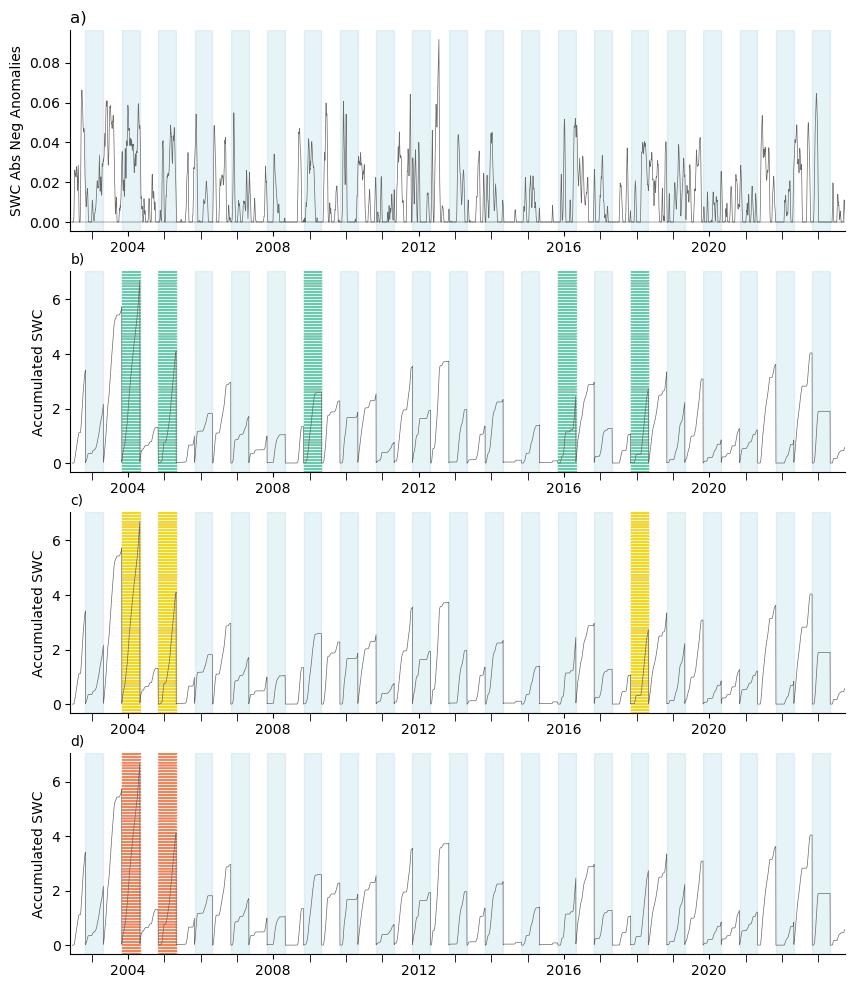

In [79]:
start_year = 2002
end_year = 2023
start_lim = pd.to_datetime(f'{start_year}-06-01')
end_lim = pd.to_datetime(f'{end_year}-09-30')
windows = {
    'crop_cycle': ('11-01', '04-30'),
}

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

ax1.plot(df_anomalies['time'], df_anomalies['negative_anomaly'], lw=0.5, color='dimgray')
ax1.set_title("a)", loc='left')
ax1.set_ylabel('SWC Abs Neg Anomalies')
ax1.set_xlim([start_lim, end_lim])

for i, (key, dates) in enumerate(act_years.items()):
    ax = [ax2, ax3, ax4][i]
    color = ['mediumaquamarine', 'gold', 'coral'][i]
    dates_ = pd.DatetimeIndex([])
    for year in dates:
        dates_act = pd.date_range(start=str(year) + '-11-01', end=str(year+1)+'-04-30')
        dates_ = dates_.append(dates_act)
    for activation_date in dates_:
        ax.axvline(activation_date, color=color, linestyle='dotted', lw=0.8, alpha=0.8)

for i, ax in enumerate((ax2, ax3, ax4)):
    ax.plot(df_anomalies['time'], df_anomalies['cum_neg_anomaly'], lw=0.5, color='dimgray', label="Accumulated SWC anomalies")
    ax.set_title("b)", loc='left')
    ax.set_ylabel("Accumulated SWC")
    #ax.set_ylim([-5, 5])
    ax.set_xlim([start_lim, end_lim])
    ax.set_title(f"{chr(97 + i + 1)})", loc='left', fontsize=10)

for ax in (ax1, ax2, ax3, ax4):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ax == ax1:
        ax.axhline(y=0, color='black', linestyle='-', lw=0.25)

    for stage, (start, end) in windows.items():
        for year in range(start_year, end_year + 1):
            start_date = f'{year}-{start}'
            end_date = f'{year+1}-{end}'
            ax.axvspan(start_date, end_date, color='lightblue', alpha=0.3)
    
    # minor ticks for the years
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    ax.tick_params(axis='x', which='minor', length=6, color='black')

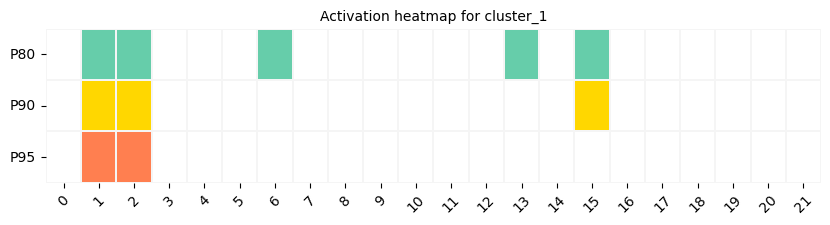

In [80]:
create_heatmap(df_year, index=1)

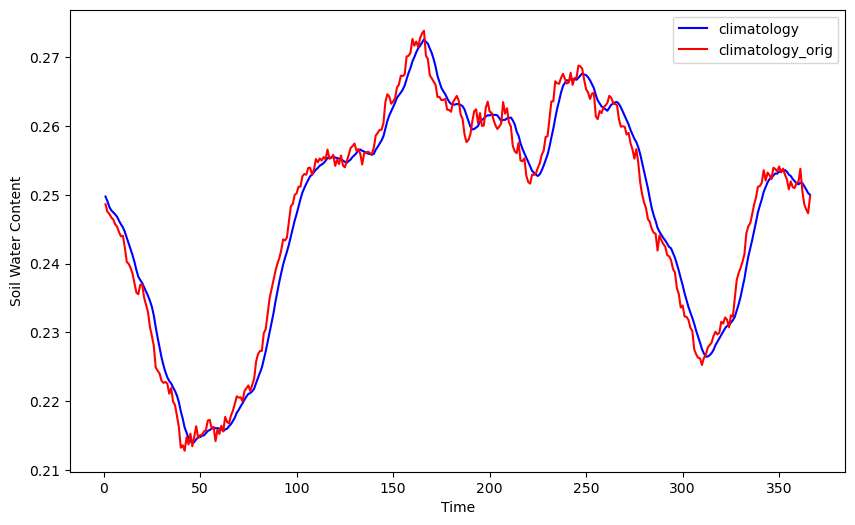

In [29]:
ds_location_ = ds.groupby('dayofyear').mean().mean(dim='cluster')
ds_location = ds_rolling.groupby('dayofyear').mean().mean(dim='cluster')

plt.figure(figsize=(10, 6)) 
plt.plot(ds_location.dayofyear, ds_location.climatology, label='climatology', color='blue') 
plt.plot(ds_location_.dayofyear, ds_location_.climatology, label='climatology_orig', color='red')
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

# Create full data with daily cycles cumulated only on summer season

In [36]:
files = os.listdir(dop)
files = [f for f in files if f.startswith('drought_daily_activation_dates_')]

In [38]:
gdf = gpd.read_file(dgp + 'dict_canton.gpkg')

In [43]:
df_list = []
for f in files:
    id = f[38:].split(".")[0]
    df = pd.read_csv(dop + f)
    df['id_canton'] = int(id)
    df = df.rename(columns={'cluster':'id_cluster'})
    df_list.append(df)
df_full = pd.concat(df_list,axis=0)

In [44]:
df_full['cum_neg_anomaly'] = np.where(
    df_full['flag_summer'] == 0,
    0,
    df_full['cum_neg_anomaly']
)

In [45]:
df_full = df_full.merge(
    gdf[['id_canton', 'id_cluster', 'new_id']],
    how = 'left',
    on = ['id_canton', 'id_cluster']
)
df_full.head(3)


,time,id_cluster,week,dayofyear,crop_year,flag_summer,crop_cycle,swc,swc_adjusted,climatology,anomaly,negative_anomaly,cum_neg_anomaly,id_canton,new_id
0,2002-06-16,1.0,24,167,2002,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,164,139-5
1,2002-06-17,1.0,25,168,2002,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,164,139-5
2,2002-06-18,1.0,25,169,2002,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,164,139-5


In [46]:
df_full = df_full[['id_canton','id_cluster','new_id','time', 'dayofyear', 'crop_year', 'flag_summer', 'swc_adjusted', 'climatology', 'anomaly', 'cum_neg_anomaly']].copy()

In [ ]:
df_full.to_parquet(dop + 'drought_daily_activation_dates.parquet', compression='gzip')

# Export full data with yearly accumulated anomalies with new id

In [71]:
files = os.listdir(dop)
files = [f for f in files if f.startswith('drought_yearly_activation_dates_')]

In [72]:
gdf = gpd.read_file(dgp + 'dict_canton.gpkg')

In [73]:
df_list = []
for f in files:
    df = pd.read_csv(dop + f)
    cols_to_bin = [col for col in df.columns if col.endswith('_activation_date')]
    for col in cols_to_bin:
        df[col] = df[col].astype(int) 
    df_list.append(df)
df_full = pd.concat(df_list,axis=0)

In [74]:
df = df_full.merge(
    gdf[['id_canton', 'id_cluster', 'new_id']],
    how = 'left',
    on = ['id_canton', 'id_cluster']
)
df.head(3)

,id_canton,id_cluster,year,P80_activation_date,P90_activation_date,P95_activation_date,P80_trigger,P90_trigger,P95_trigger,accumulated_anomaly,percentile,new_id
0,106,7.0,2002,0,0,0,NaN,NaN,NaN,1.71,42.9,131-0
1,106,7.0,2003,0,0,0,NaN,NaN,NaN,5.45,71.4,131-0
2,106,7.0,2004,0,0,0,NaN,NaN,NaN,4.40,66.7,131-0


In [ ]:
df.to_csv(dop + 'drought_yearly_activation_dates.csv', index=False)

In [75]:
df = pd.read_csv(dop + 'drought_yearly_activation_dates.csv')
df.head(3)

,id_canton,id_cluster,year,P80_activation_date,P90_activation_date,P95_activation_date,P80_trigger,P90_trigger,P95_trigger,accumulated_anomaly,percentile,new_id
0,43,1.0,2010,0,0,0,NaN,NaN,NaN,0.76,0.0,122-3
1,43,1.0,2021,0,0,0,NaN,NaN,NaN,0.84,4.8,122-3
2,43,1.0,2019,0,0,0,NaN,NaN,NaN,0.85,9.5,122-3
